# Task 2a: Sign Detection with YOLOv8

**Student:** Thaina Helena De Oliveira Alves  
**Student ID:** 0150103A    
**Model:** YOLOv8


This notebook implements a YOLOv8 object detector to detect Maltese traffic signs. It covers:
1.  **Dataset Preparation**: Loading images and annotations.
2.  **Model Training**: Fine-tuning a pre-trained `YOLOv8` model.
3.  **Evaluation**: Calculating F1-Scores.
4.  **Inference & Analytics**: Visualising and counting detections signs per image.

Mounting drive and changing directories:

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
os.listdir()

['.gitignore',
 'README.md',
 'merged_input.json',
 'Assignment Material',
 'results',
 'runs',
 'yolov8m.pt',
 'models',
 'yolo11n.pt']

In [6]:
os.chdir("drive")
os.chdir("MyDrive")
os.chdir("Computer-Vision-2-main")

In [ ]:
# --- Environment & Imports ---
from __future__ import annotations
import importlib, subprocess, sys, json, os
from ultralytics import YOLO
import glob
import matplotlib.pyplot as plt
import cv2
import yaml 

def ensure_package(pkg: str, import_name: str | None = None, pip_name: str | None = None):
    try:
        return importlib.import_module(import_name or pkg)
    except ImportError:
        pip_target = pip_name or pkg
        print(f"Installing missing package: {pip_target}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_target], stdout=subprocess.DEVNULL)
        return importlib.import_module(import_name or pkg)

torch = ensure_package("torch")
yolov8 = ensure_package("ultralytics")

torch.manual_seed(42)
print("Environment ready: all dependencies installed and imported.")

Environment ready: all dependencies installed and imported.


## 1. Dataset Preparation
The dataset for the YOLOv8 model is prepared automatically by the data.yaml file in the YOLO_COCO dataset

In [11]:
# Path to the data.yaml file
DATA_YAML = "/content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO/data.yaml"


In [12]:
print(os.path.exists(DATA_YAML))


True


## 2. Model Fine-Tuning & Training
We load the YOLOv8 model, also pre-trained on the large-scale COCO dataset, and use Ultralytics' **tune** method to find the optimal hyperparameters for our model.

We then train the model until it stops improving. The model is configured to train for 100 epochs, but to stop training early in case no improvements are seen after 20 consecutive epochs.

In [ ]:
# Loads a pre-trained YOLOv8 model
model = YOLO('yolo8m.pt')

model.tune(
    data=DATA_YAML,
    epochs=15,
    imgsz=640,
    batch=8,
    patience=5,
    iterations=15,
    optimizer="AdamW",
    project="models",
    name="yolov8_tuning",
    resume=True
)

In [ ]:
# Path to the hyperparameters.yaml file
BEST_HYP = "models/yolov8_tuning/best_hyperparameters.yaml"
print(os.path.exists(BEST_HYP))

# opening yaml file and saving contents to a dict
with open(BEST_HYP, "r") as f:
    best_hyp = yaml.safe_load(f)

# turning certain keys of best_hyp into int datatype as that is what is expected by YOLO
INT_KEYS = {
    "epochs",
    "batch",
    "patience",
    "warmup_epochs",
    "close_mosaic"
}
for k in INT_KEYS:
    if k in best_hyp:
        best_hyp[k] = int(best_hyp[k])

In [ ]:
# display the hyperparameters we will be training the model with
print(best_hyp)

## 2. Model Training
We load the YOLOv8 model pre-trained on COCO and fine tune it until it stops improving. The model is configured to train for 100 epochs, but to stop training early in case no improvements are seen after 20 consecutive epochs.

In [ ]:
# Trains the model and gets the training results
results = model.train(
    data=DATA_YAML,
    epochs=100,
    patience=20,
    imgsz=640,
    batch=8,
    **best_hyp,
    project='models',
    name='yolov8_final',
    exist_ok=True
)

Ultralytics 8.4.2 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, over

## 3. Evaluating on Test Set
This section loads the best YOLOv8 model and evaluates its performance on the test set, generating metrics and plots to assess detection accuracy.

In [ ]:
#reloading the best model
best_model = YOLO('models/yolov8_final/weights/best.pt')

# evaluate the best trained model on the test set and generate plots
best_model.val(
    data=DATA_YAML,
    split="test",
    plots=True
    project="runs"
    name="yolov8"
)


Ultralytics 8.4.2 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 93 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 1.0±1.3 ms, read: 164.3±232.1 MB/s, size: 1242.9 KB)
val: Scanning /content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO/labels/test... 116 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 116/116 2.3it/s 51.5s
val: New cache created: /content/drive/MyDrive/Computer-Vision-2-main/Assignment Material/YOLO_COCO/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.9s/it 15.3s
                   all        116        130      0.953       0.67      0.777      0.641
Blind-Spot Mirror (Convex)         14         15       0.92      0.933      0.896      0.753
    No Entry (One Way)         37         40       0.93      0.663      0.879      0.671
No Through Road (T-Sign)          7          7      0.

## 4. Analytics and Visualisation
This section provides functions and tools to visualise the results and analytics of the YOLOv8 model.

In [ ]:
# YOLOv8's best model's outputs
test_dir = 'runs/yolov8'

# Function to display images from a folder in a grid format
def show_images_from_folder(
    folder,
    title,
    patterns,
    cols = 2,
    img_size=5
):

    image_paths = []
    for pattern in patterns:
        image_paths.extend(glob.glob(os.path.join(folder, pattern)))
    image_paths.sort()

    if not image_paths:
        print(f'No images found in {folder}')
        return

    n = len(image_paths)
    rows = (n + cols - 1) // cols # Logic to get number of rows needed

    # Figure size scales with rows
    fig_width = cols * img_size
    fig_height = rows * img_size

    # Create subplots
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(fig_width, fig_height),
        constrained_layout=True
    )

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    for ax, img_path in zip(axes, image_paths):
        img = plt.imread(img_path)
        ax.imshow(img)
        ax.set_aspect('equal')
        ax.axis('off')

    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close(fig)


***Evaluation PLots***
Displays key evaluation plots such as the confusion matrix, precision-recall curves and F1-curves to help interpret the model's performance.


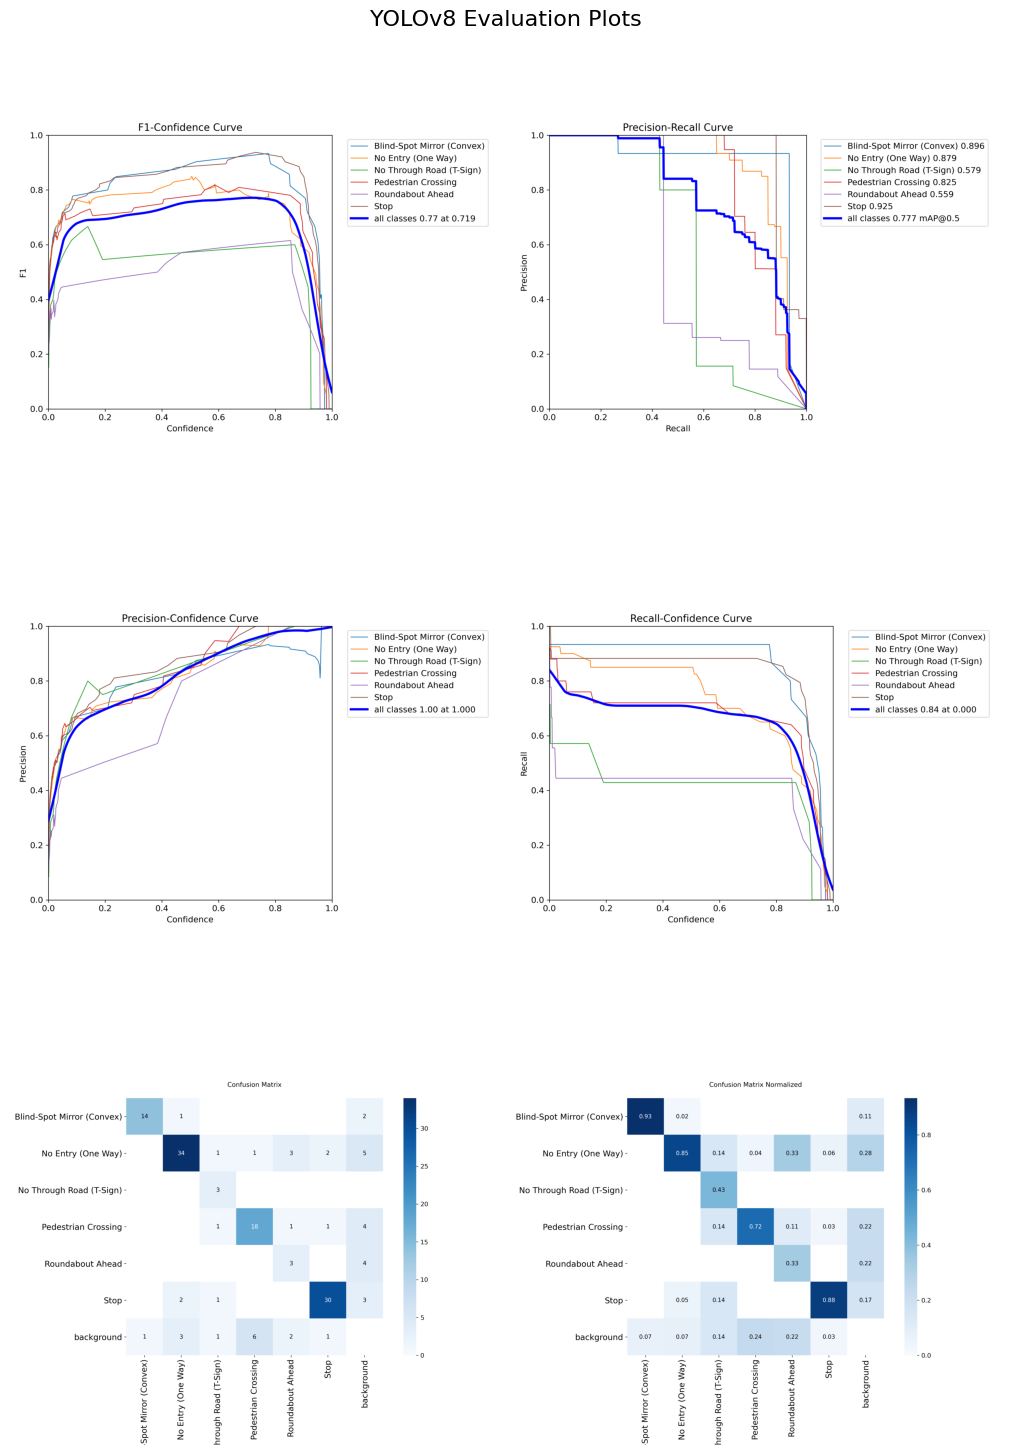

In [ ]:
plot_patterns = (
    'confusion_matrix*.png',
    '*curve*.png',
)

show_images_from_folder(
    test_dir,
    title='YOLOv8 Evaluation Plots',
    patterns=plot_patterns
)


***Labels and Predictions***

Shows sample images with predicted bounding boxes and labels, allowing for a visual comparison between model predictions and ground truth.

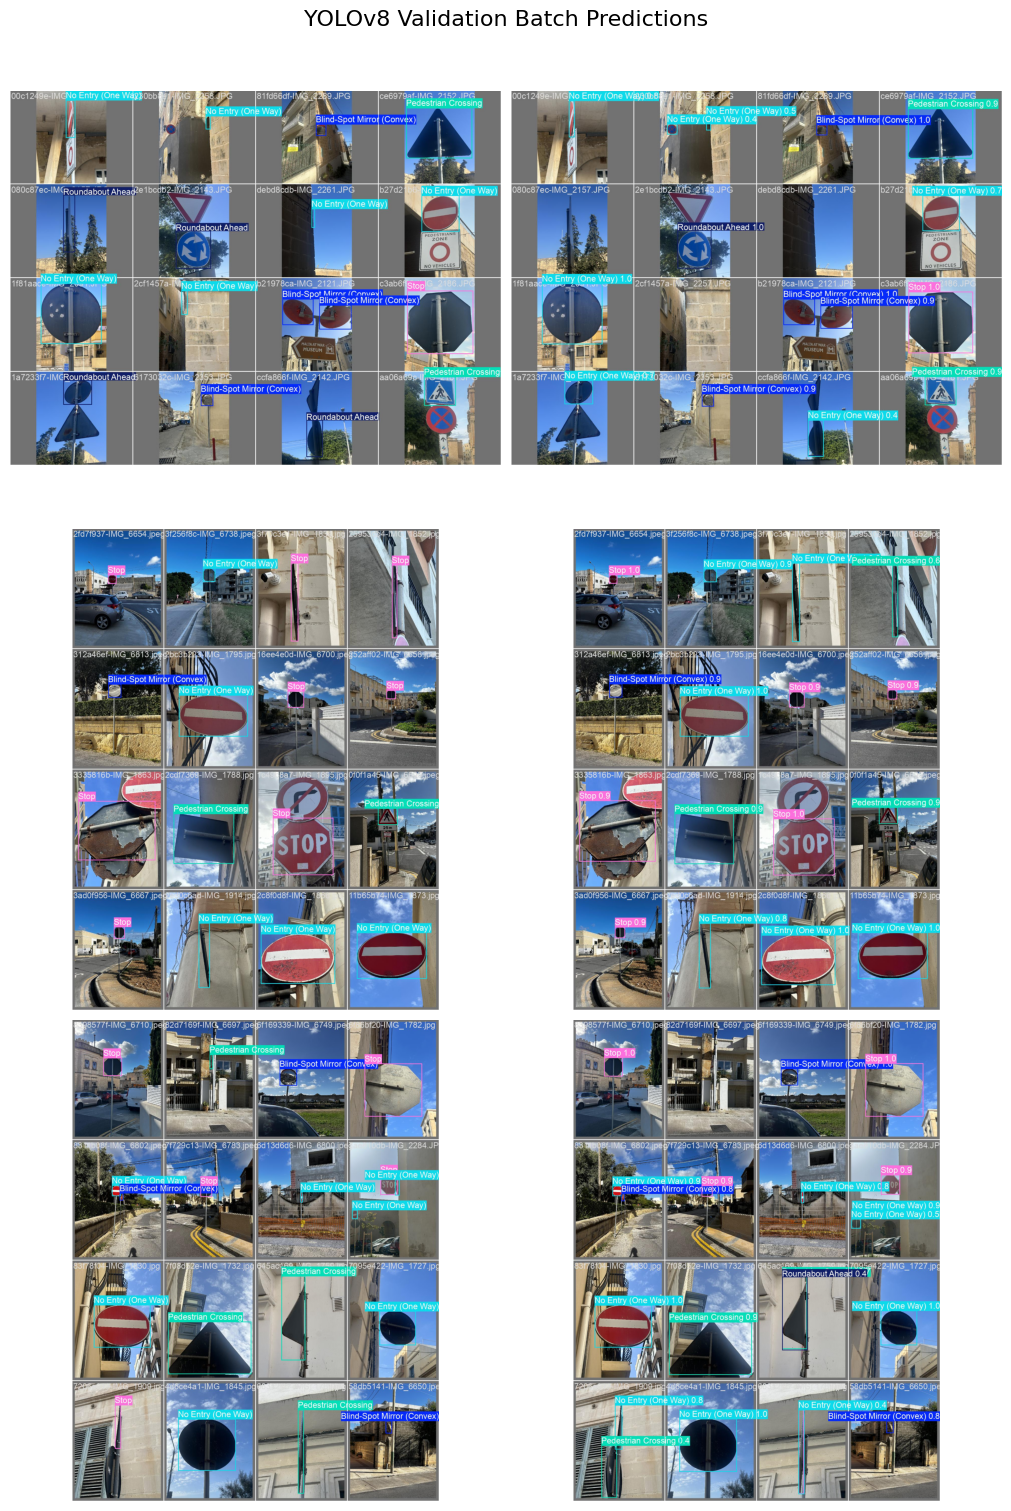

In [ ]:
val_batch_patterns = ('val_batch*.jpg', 'val_batch*.png')

show_images_from_folder(
    test_dir,
    title='YOLOv8 Batch Predictions',
    patterns=val_batch_patterns
)


In [ ]:
print("\nVisualizing Sample Predictions:")

# Gets list of validation images
test_image_paths = sorted(glob.glob('Assignment Material/YOLO_COCO/images/test/*'))

# Loops and predicts each input image
for i, img_path in enumerate(test_image_paths):

    results = best_model(img_path, verbose=False)

    # Visualises image
    for result in results:

        # Gets number of detections and their chosen attribute (class name)
        num_signs = len(result.boxes) if hasattr(result, 'boxes') else 0
        if hasattr(result, 'names') and hasattr(result, 'boxes'):
            class_ids = result.boxes.cls.cpu().numpy().astype(int)
            attributes = [result.names[cid] for cid in class_ids]
        else:
            attributes = []
        print(f"Image {i}: {num_signs} signs detected. Attributes: {attributes}")

        img_array = result.plot() 
            
        plt.figure(figsize=(8, 8))
        # Converts BGR to RGB for matplotlib
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.title(f"Image {i} Prediction")
        plt.axis('off')
        plt.show()